# 0. Importing Necessary Packages

In [1]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'pandas', 'astropy', 'pyraf']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.21.5
matplotlib: ver 3.5.1
pandas: ver 1.3.5
astropy: ver 3.2.3
pyraf: ver 2.1.15


In [2]:
# Matplotlib backend
%matplotlib notebook

# Importing necessary modules
import time
import numpy as np
import glob, os, copy
from matplotlib import pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

current_dir = os.getcwd()    # Current working directory
login_file = "/data2/iraf/login.cl"    # Please give the absolute path of your 'login.cl' file

# Reading 'login.cl' file
f = open(login_file, "r")
ll = f.readlines()
f.close()

# Finding the string for home directory in 'login.cl' file
line_homedir = np.argwhere(pd.Series(ll).str.startswith("set\thome\t\t=").values)[0][0]
idx_start = ll[line_homedir].find('"')
idx_end = ll[line_homedir].find('"', idx_start+1)
dir_iraf = ll[line_homedir][idx_start+1:idx_end]    # Home directory recoded in the 'login.cl' file
print(dir_iraf)    # For check

# Importing IRAF
os.chdir(dir_iraf)
from pyraf import iraf
os.chdir(current_dir)

/data2/iraf/


# 1. Displaying the Images

### 1) Image names

In [3]:
dir_img = "/home/hhchoi1022/Desktop/"
imglist = [dir_img+"NGC4442.fits"]
os.chdir(dir_img)
n_img = len(imglist)
imglist

['/home/hhchoi1022/Desktop/NGC4442.fits']

### 2) Running DS9

In [7]:
# You can also run this command in terminal.
ds9_options = "-scalemode zscale -scale lock yes -frame lock image "
names = ""
for i in np.arange(n_img):
    names += imglist[i]+" "
ds9_command = "ds9 "+ds9_options+names+"&"
print('Running "'+ds9_command+'" in the terminal...')
os.system(ds9_command)

Running "ds9 -scalemode zscale -scale lock yes -frame lock image /home/hhchoi1022/Desktop/NGC4442.fits &" in the terminal...


0

# 2. Running IRAF/Ellipse Task 

### 1) Importing IRAF/Ellipse Task

In [5]:
# IRAF/ellipse task is in the STSDAS package (IRAF external package)
iraf.stsdas()
iraf.stsdas.analysis()
iraf.stsdas.analysis.isophote()



      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |
      |                   STSDAS Version 3.18.3                    |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      |                                                            |
      +------------------------------------------------------------+


### 2) Parameter Information of IRAF/Ellipse Task

### 3) Declaration of Function (for convenience!)

In [6]:
def fit_ellipse(input_image, output_table=None, interactive=False,
                model_image=None, residual_image=None, display=False, data_file=None,
                x0=100.0, y0=100.0, ellip0=0.1, pa0=45.0, sma0=10.0,  # geompar
                minsma=0.0, maxsma=50.0, step=1.0, linear=False, recenter=True,  # geompar
                minit=10, maxit=100, hcenter=False, hellip=False, hpa=False,  # controlpar
                usclip=3.0, lsclip=3.0, nclip=0,  # samplepar
                mag0=25.0, refer=1.0, zerolevel=0.0,  # magpar
                backgr=0.0, interp='linear'):  # bmodel

    '''
    # --- basic input parameters --- #
    input_image - input image name ('[FILENAME].fits')
    output_table - output table name (default: '[FILENAME].tab')
    interactive - interactive (boolean, default: False)
    model_image - output model image (default: '[FILENAME]_mod.fits')
    residual_image - output residual image (default: '[FILENAME]_res.fits')
    data_file - output data file (default: '[FILENAME].dat')
    display - display the results or not? (boolean, default: False)
    
    # --- geompar set --- #
    x0, y0 - initial isophote center X, Y [pixel]
    ellip0, pa0 - initial ellipticity, position angle [degree]
    sma0 - initial semi-major axis (SMA) length [pixel]
    minsma - minimum SMA length for fitting [pixel] (default: 0.0)
    maxsma - maximum SMA length for fitting [pixel]
    step - SMA step between successive ellipses [pixel OR relative value]
    linear - linear SMA step for fitting? (boolean, default: False)
    recenter - do you allow to re-center x0 & y0? (boolean, default: False)
    
    # --- controlpar set --- #
    minit - minimum iteration number at each step of SMA (default: 10)
    maxit - maximum iteration number at each step of SMA (default: 100)
    hcenter - do you want to hold center fixed? (boolean, default: False)
    hellip - do you want to hold ellipticity fixed? (boolean, default: False)
    hpa - do you want to hold position angle fixed? (boolean, default: False)
    
    # --- samplepar set --- #
    usclip - upper sigma-clip criterion (default: 3)
    lsclip - lower sigma-clip criterion (default: 3)
    nclip - iteration number for the sigma clipping (default: 0)
    
    # --- magpar set --- #
    mag0 - magnitude zeropoint for sky brightness (default: 25.0)
    refer - reference count for sky brightness (default: 1.0)
    zerolevel - bias level (default: 0.0)    
    ### mag = mag0-2.5*log10((intensity-zerolevel)/refer)
    
    # --- bmodel parameter set --- #
    backgr - background level for making model image (default: 0.0)
    interp - interpolation algorithm for model image ('nearest' OR 'linear' OR 'poly3' OR 'spline', default: 'linear')    
    '''
    
    iname = input_image.split('.fits')[0].split('/')[-1]    # Image name
    if (output_table is None):
        output_table = iname+'.tab'    # Output table name
    if (model_image is None):
        model_image = iname+'_mod.fits'    # Output model image name
    if (residual_image is None):
        residual_image = iname+'_res.fits'    # Output residual image name
    if (data_file is None):
        data_file = iname+'.dat'    # Output data file name 

    # Running IRAF/ellipse task
    os.system("rm -rfv "+output_table+" colnames.lis "+data_file)  # Reset by removing the output data
    kwargs = {"x0":x0, "y0":y0, "ellip0":ellip0, "pa0":pa0, "sma0":sma0,
              "minsma":minsma, "maxsma":maxsma, "step":step, "linear":linear, "recenter":recenter,
              "minit":minit, "maxit":maxit, "hcenter":hcenter, "hellip":hellip, "hpa":hpa,
              "integrmode":"bi-linear", "usclip":usclip, "lsclip":lsclip, "nclip":nclip,
              "mag0":mag0, "refer":refer, "zerolevel":zerolevel}
    iraf.ellipse(input=input_image, output=output_table, interactive=interactive,
                 **kwargs)
    
    # Making model, residual images
    os.system("rm -rfv "+model_image+" "+residual_image)  # Reset by removing the output images
    iraf.bmodel(table=output_table, output=model_image, parent=input_image,
                backgr=backgr, interp=interp)    # bmodel task for model image
    
    iraf.imarith(input_image, "-", model_image, residual_image)    # input - model = residual
    
    if display:    # if display == True, DS9 will display input, model, and residual images.
        opt = " -scalemode zscale -scale lock yes -frame lock image "
        opt += " -tile grid mode manual -tile grid layout 3 1 "
        os.system("ds9 "+opt+input_image+" "+model_image+" "+residual_image+"&")
    
    # Reading output results
    ### output_table is not directly readable because it is a binary-format file :( 
    iraf.tlcol(output_table, nlist=1, Stdout='colnames.lis')    # Extracting column names
    iraf.tdump(table=output_table, columns="@colnames.lis", datafile=data_file)    # Making ASCII data file
    
    f = open("colnames.lis", "r")
    cc = f.readlines()
    f.close()

    colnames = []
    for line in cc:
        if not (line[0] == '#'):
            colnames.append(line.split(' ')[0])
#     print(colnames)    # column names array
    
    iso_tbl = np.genfromtxt(data_file, encoding="ascii", names=colnames)    # Reading data
    iso_df = pd.DataFrame(iso_tbl)
#     print(iso_df)    # output result data frame
    
    return iso_df

### 4) Sky Estimation (depending on your image)

In [23]:
# ----- SDSS pixel scale & Magnitude zeropoint ----- #
pixel_scale = 0.390    # arcsec/pixel (SDSS image)
mag0_g = 22.3275   # SDSS g-magnitude zeropoint for sky brightness (just for example)

#### For magnitude zeropoint, please use the given value on the website below.

* **SDSS: [SDSS Imaging Information](https://www.sdss.org/dr14/imaging/other_info/)**
* **HST: [HST ACS Zeropoint](https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints)**

#### Or you can also measure the zeropoint by yourself using (secondary) calibration in your image.

#### Pixel scale is for tranforming the unit of surface brightness from ${\rm mag/pixel^2}$ to ${\rm mag/arcsec^2}$ (or the opposite).

#### If you just want to use ${\rm mag/pixel^2}$ unit, you do not have to use pixel scale of the images.

#### However, ${\rm mag/arcsec^2}$ unit is generally used for surface photometry.

In [24]:
iraf.chdir(dir_img)

In [25]:
imgname = imglist[0]

In [26]:
from astropy.io import fits

In [27]:
# For g-band image of M105
imgname = imglist[0]
x_center, y_center = 1581.0, 1124.0    # depending on your object & image size
r0 = 200.0    # outer boundary for sky estimation (up to you)
iraf.imcopy(input = imgname+f'[{int(x_center)-int(3*r0)}:{int(x_center)+int(3*r0)},{int(y_center)-int(3*r0)}:{int(y_center)+int(3*r0)}]', output = 'crop_'+os.path.basename(imgname))
imgname = 'crop_'+os.path.basename(imgname)
#iraf.wcsreset(image = imgname+'[1]', wcs = 'physical')
# --- Background estimation for determining backgroun level --- #
### (This is up to you! You do not have to do this if the background level in your images can be obviously determined.)
img = fits.getdata(imgname, ext=0)
img

x1d = np.arange(0, img.shape[1], 1)
y1d = np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(x1d, y1d, sparse=True)
z = ((xx-x_center)**2.0 + (yy-y_center)**2.0 - r0**2.0)
sky_region = (z > 0.0)

avg, med, std = sigma_clipped_stats(img[sky_region], sigma=3.0)
sky_val, sky_sig = 3.0*med - 2.0*avg, std
print("Image: "+imgname)
print("sky level: {0:.4f}".format(sky_val))
print("sky sigma: {0:.4f}".format(sky_sig))
# ---------- #

/home/hhchoi1022/Desktop/NGC4442.fits[981:2181,524:1724] -> crop_NGC4442.fits
Image: crop_NGC4442.fits
sky level: 25.2219
sky sigma: 0.5666


이미지 중심부 은하 마스킹하고, sigma clipping 하기. 
주변부 source detection 하고 sigma clipping 해서 background 다시 구하자.


<IPython.core.display.Javascript object>


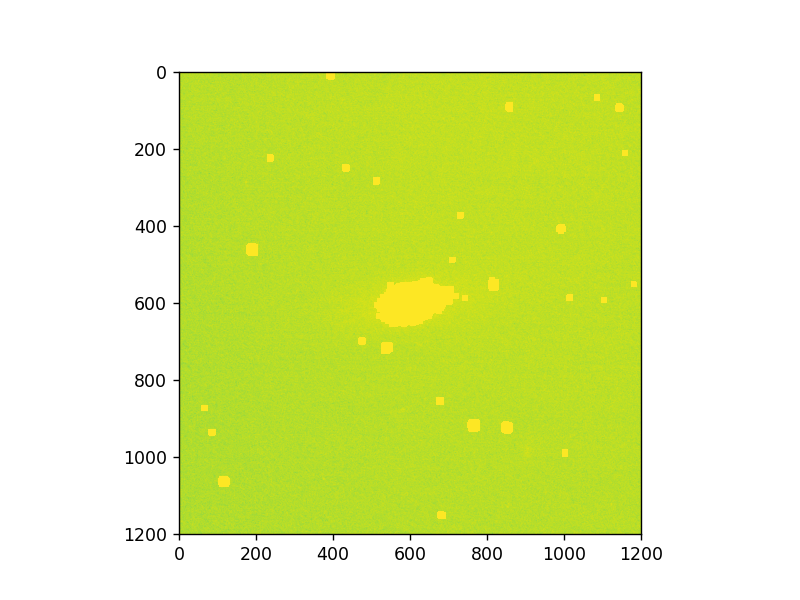

In [28]:
from photutils.segmentation import make_source_mask
from astropy.visualization import simple_norm
data_m1 =np.ma.array(img, mask = ~sky_region)
sourcemask = make_source_mask(data_m1, nsigma = 3, npixels = 3, dilate_size= 11)
data_m2 = np.ma.array(data_m1, mask = sourcemask)
norm = simple_norm(data_m2[sky_region], 'log')
plt.figure()
plt.imshow(data_m2, norm = norm )
result = data_m2.data[~data_m2.mask]
sky_val, sky_sig = np.median(result[~np.isnan(result)]), np.std(result[~np.isnan(result)])
#sky_val, sky_sig = np.median(data_m2.data[~data_m2.mask]), np.std(data_m2.data[~data_m2.mask])


In [30]:
data = fits.getdata(imgname)
hdr = fits.getheader(imgname)

In [31]:
hdr['EXTEND'] = False

In [32]:
fits.writeto('final_NGC4442.fits', data, header = hdr, overwrite = True)

In [33]:
imgname = 'final_NGC4442.fits'

In [34]:
iraf.wcsreset(image = imgname, wcs = 'physical')

Initializing wcs physical for image final_NGC4442.fits


In [37]:
depth_g = -2.5*np.log10(3*sky_sig*np.sqrt(np.pi*(2.0*1.5/0.39)**2))+mag0_g
print(depth_g)

18.907443268028363


### 5) Running IRAF/Ellipse Task & Showing the Results

In [38]:
# Check and set initial center
ds9_options = "-scalemode zscale -scale lock yes -frame lock image "
names = ""
names += imgname
ds9_command = "ds9 "+ds9_options+names+"&"
print('Running "'+ds9_command+'" in the terminal...')
os.system(ds9_command)

Running "ds9 -scalemode zscale -scale lock yes -frame lock image final_NGC4442.fits&" in the terminal...


0

In [39]:
x_center = int(input('Initial guess for x_center : '))
y_center = int(input('Initial guess for y_center : '))

Initial guess for x_center : 601
Initial guess for y_center : 601


In [42]:
sky_val_g = sky_val    # sky brightness (unit: pixel count)
rmax =200.0    # maximum SMA (up to you)
kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.1, "sma0":5.0,
          "minsma":0.1, "maxsma":rmax, "step":0.05,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":1, "mag0":mag0_g, "refer":sky_val_g,    # https://www.sdss.org/dr12/algorithms/magnitudes/
          "backgr":sky_val_g, "interp":"linear"}  # Here you can change input (default) parameter if needed!
iso_df_g = fit_ellipse(imgname, display=True, **kwargs)

# def fit_ellipse(input_image, output_table=None, interactive=False,
#                 model_image=None, residual_image=None, display=False, data_file=None,
#                 x0=100.0, y0=100.0, ellip0=0.1, pa0=45.0, sma0=10.0,  # geompar
#                 minsma=0.0, maxsma=50.0, step=1.0, linear=False, recenter=False,  # geompar
#                 minit=10, maxit=100, hcenter=False, hellip=False, hpa=False,  # controlpar
#                 usclip=3.0, lsclip=3.0, nclip=0,  # samplepar
#                 mag0=25.0, refer=1.0, zerolevel=0.0,  # magpar
#                 backgr=0.0, interp='linear'):  # bmodel

removed 'final_NGC4442.tab'
removed 'colnames.lis'
removed 'final_NGC4442.dat'
Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.00    67.01(  0.61) 0.088(0.009)  85.06( 3.13) 0.047   30   0    20    0
   5.25    65.33(  0.59) 0.091(0.009)  84.60( 2.92) 0.046   32   0    10    0
   5.51    63.83(  0.59) 0.100(0.008)  85.23( 2.55) 0.044   33   0    10    0
   5.79    62.25(  0.58) 0.106(0.008)  85.41( 2.31) 0.042   35   0    10    0
   6.08    60.67(  0.57) 0.111(0.008)  86.36( 2.17) 0.041   36   0    10    0
   6.38    59.13(  0.53) 0.118(0.007)  85.83( 1.94) 0.041   38   0    10    0
   6.70    57.67(  0.54) 0.123(0.008)  85.13( 1.91) 0.042   40   0    10    0
   7.04    56.32(  0.50) 0.132(0.007)  85.13( 1.67) 0.042   41   0   10

   1.41    95.43(  0.50) 0.101(0.051) -72.40(15.64) 0.261   13   0    10    0
   1.34    95.92(  0.46) 0.146(0.051) -73.98(11.12) 0.281   13   0    10    0
   1.28    96.34(  0.43) 0.183(0.053) -75.17( 9.38) 0.321   13   0    10    0
   1.21    96.68(  0.42) 0.210(0.057) -76.56( 8.89) 0.345   13   0    10    0
   1.16    96.93(  0.42) 0.219(0.061) -78.42( 9.30) 0.385   13   0    10    0
   1.10    97.06(  0.36) 0.212(0.061) -79.20( 9.45) 0.396   13   0    10    0
   1.05    97.18(  0.32) 0.202(0.057) -79.84( 9.30) 0.376   13   0    10    0
   1.00    97.30(  0.28) 0.194(0.054) -80.24( 9.17) 0.355   13   0    10    0
   0.95    97.42(  0.27) 0.184(0.054) -80.99( 9.49) 0.343   13   0    10    0
   0.91    97.53(  0.25) 0.176(0.055) -81.22(10.08) 0.340   13   0    10    0
   0.86    97.62(  0.25) 0.169(0.060) -82.39(11.48) 0.369   13   0    10    0
   0.82    97.71(  0.26) 0.172(0.071) -84.47(13.32) 0.428   13   0    10    0
   0.78    97.80(  0.25) 0.203(0.074) -85.13(12.00) 0.475   13  

In [12]:
# Columns in the result array
iso_df_g.columns

Index(['SMA', 'INTENS', 'INT_ERR', 'PIX_VAR', 'RMS', 'ELLIP', 'ELLIP_ERR',
       'PA', 'PA_ERR', 'X0', 'X0_ERR', 'Y0', 'Y0_ERR', 'GRAD', 'GRAD_ERR',
       'GRAD_R_ERR', 'RSMA', 'MAG', 'MAG_LERR', 'MAG_UERR', 'TFLUX_E',
       'TFLUX_C', 'TMAG_E', 'TMAG_C', 'NPIX_E', 'NPIX_C', 'A3', 'A3_ERR', 'B3',
       'B3_ERR', 'A4', 'A4_ERR', 'B4', 'B4_ERR', 'NDATA', 'NFLAG', 'NITER',
       'STOP', 'A_BIG', 'SAREA'],
      dtype='object')

In [13]:
# Some useful information in the results
iso_df_g[["SMA","INTENS","X0","Y0","MAG","MAG_LERR","MAG_UERR","ELLIP","PA","A4","B4"]].head(10)

SMA    INTENS        X0        Y0       MAG  MAG_LERR  MAG_UERR  \
0  0.000000  52.17975  422.1287  456.1275  11.59443       NaN       NaN   
1  0.536637  49.63029  422.1287  456.1275  11.64882  0.001705  0.001702   
2  0.579568  49.44893  422.1390  456.1382  11.65279  0.001828  0.001825   
3  0.625934  49.23426  422.1604  456.1482  11.65752  0.001929  0.001926   
4  0.676008  49.01455  422.1671  456.1591  11.66237  0.002112  0.002107   
5  0.730089  48.77859  422.1870  456.1742  11.66761  0.002234  0.002229   
6  0.788496  48.51612  422.2044  456.1918  11.67347  0.002416  0.002410   
7  0.851576  48.19320  422.2187  456.2048  11.68072  0.002446  0.002440   
8  0.919702  47.77483  422.2213  456.2091  11.69019  0.002228  0.002223   
9  0.993278  47.25498  422.2054  456.2042  11.70207  0.001921  0.001917   

      ELLIP        PA        A4        B4  
0       NaN       NaN       NaN       NaN  
1  0.050859 -68.06218 -0.066634  0.000619  
2  0.060189 -68.44929 -0.065586  0.004201  
3  0.060189 -64.20669 -0.063011 -0.026509  
4  0.060189 -67.65422 -0.064346 -0.003065  
5  0.063954 -65.16821 -0.062617 -0.020206  
6  0.059856 -65.16821 -0.056346 -0.017766  
7  0.059856 -62.82444 -0.036038 -0.023224  
8  0.057776 -61.13002 -0.014840 -0.017436  
9  0.050714 -57.31984 -0.012776 -0.015156

# 3. Surface Photometry Example #1 (Elliptical, M105)

Image: /data2/CLASS/astronomicalobservation/Combined_images/NGC4442-r.fits
sky level: 0.0044
sky sigma: 0.0256


<IPython.core.display.Javascript object>


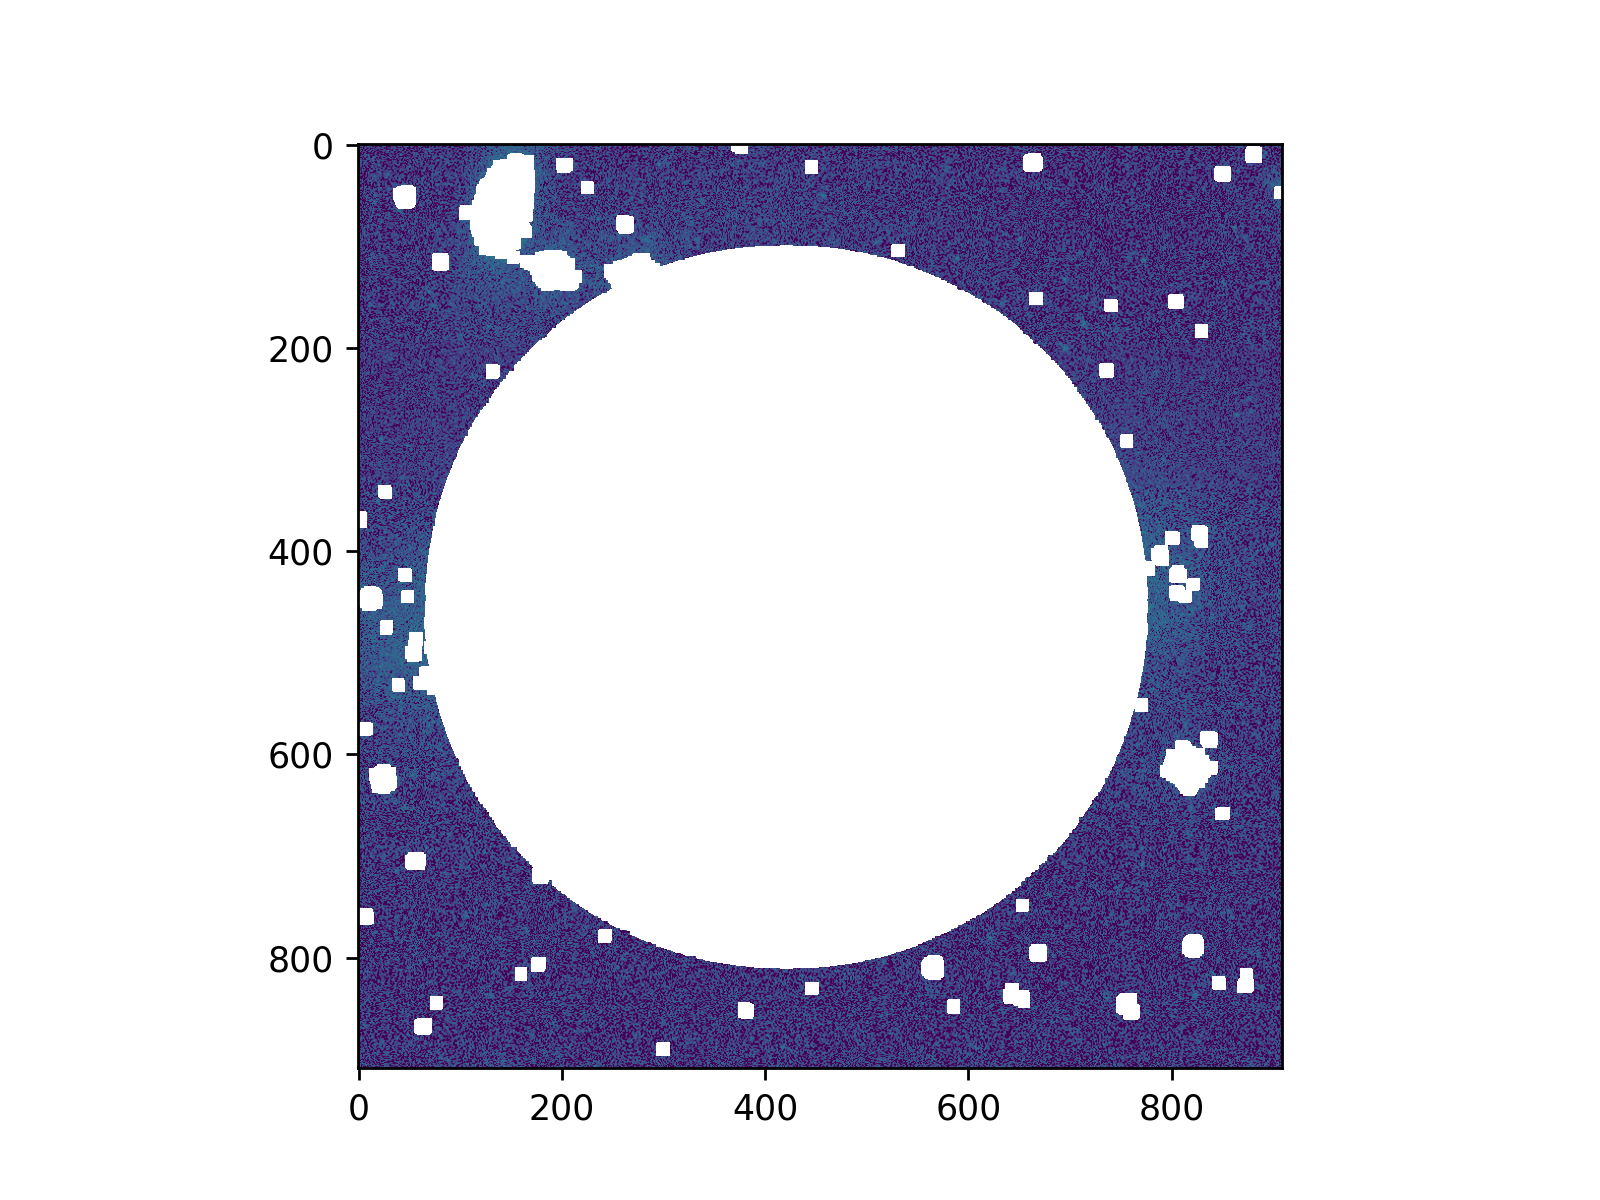

removed 'NGC4442-r.tab'
removed 'colnames.lis'
removed 'NGC4442-r.dat'
Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.00    44.99(  0.22) 0.162(0.003)  89.26( 0.49) 0.013   29   0    20    0
   5.40    41.81(  0.15) 0.166(0.002)  88.91( 0.33) 0.015   31   0    10    0
   5.83    38.79(  0.21) 0.172(0.002)  88.46( 0.46) 0.015   34   0    10    0
   6.30    35.99(  0.19) 0.181(0.002)  88.09( 0.39) 0.014   36   0    10    0
   6.80    33.40(  0.15) 0.189(0.002)  87.73( 0.30) 0.015   39   0    10    0
   7.35    31.01(  0.18) 0.199(0.002)  87.67( 0.35) 0.014   41   0    10    0
   7.93    28.75(  0.16) 0.208(0.002)  87.50( 0.31) 0.013   44   0    10    0
   8.57    26.60(  0.13) 0.215(0.002)  87.51( 0.25) 0.014   48   0    10    0
 

IMAGE    t /data2/CLASS/astronomicalobservation/Combined_images/NGC4442-r.fits


In [14]:
# For g-band image of M105
mag0_r = 22.5
imgname = "/data2/CLASS/astronomicalobservation/Combined_images/NGC4442-r.fits"
x_center, y_center = 421.0, 455.0    # depending on your object & image size
r0 = 350.0    # outer boundary for sky estimation (up to you)

# --- Background estimation for determining backgroun level --- #
### (This is up to you! You do not have to do this if the background level in your images can be obviously determined.)
img = fits.getdata(imgname, ext=0)

x1d = np.arange(0, img.shape[1], 1)
y1d = np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(x1d, y1d, sparse=True)
z = ((xx-x_center)**2.0 + (yy-y_center)**2.0 - r0**2.0)
sky_region = (z > 0.0)

avg, med, std = sigma_clipped_stats(img[sky_region], sigma=3.0)
sky_val, sky_sig = 3.0*med - 2.0*avg, std
print("Image: "+imgname)
print("sky level: {0:.4f}".format(sky_val))
print("sky sigma: {0:.4f}".format(sky_sig))
# ---------- #
from photutils.segmentation import make_source_mask
from astropy.visualization import simple_norm
data_m1 =np.ma.array(img, mask = ~sky_region)
sourcemask = make_source_mask(data_m1, nsigma = 3, npixels = 3, dilate_size= 11)
data_m2 = np.ma.array(data_m1, mask = sourcemask)
norm = simple_norm(data_m2[sky_region], 'log')
plt.figure()
plt.imshow(data_m2*10, norm = norm )
sky_val, sky_sig = np.median(data_m2.data[~data_m2.mask]), np.std(data_m2.data[~data_m2.mask])
depth_r = -2.5*np.log10(5*sky_sig*np.sqrt(np.pi*(1.44/0.396)**2))+22.5
sky_val_r = sky_val    # sky brightness (unit: pixel count)
rmax = 800.0    # maximum SMA (up to you)
kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.3, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.08,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":3, "mag0":mag0_r, "refer":sky_val_r,    # https://www.sdss.org/dr12/algorithms/magnitudes/
          "backgr":sky_val_r, "interp":"linear"}  # Here you can change input (default) parameter if needed!
iso_df_r = fit_ellipse(imgname, display=True, **kwargs)

# def fit_ellipse(input_image, output_table=None, interactive=False,
#                 model_image=None, residual_image=None, display=False, data_file=None,
#                 x0=100.0, y0=100.0, ellip0=0.1, pa0=45.0, sma0=10.0,  # geompar
#                 minsma=0.0, maxsma=50.0, step=1.0, linear=False, recenter=False,  # geompar
#                 minit=10, maxit=100, hcenter=False, hellip=False, hpa=False,  # controlpar
#                 usclip=3.0, lsclip=3.0, nclip=0,  # samplepar
#                 mag0=25.0, refer=1.0, zerolevel=0.0,  # magpar
#                 backgr=0.0, interp='linear'):  # bmodel

totmag_r = -2.5*np.log10(np.sum(iso_df_r['INTENS'] * iso_df_r['NDATA'])) + 22.5
iso_df_r['MAG'] = -2.5*np.log10(iso_df_r['INTENS']) + 22.5

### 1) $i$-band ($g$-band for M105 has already been done above!)

In [15]:
# -------------------------- #
# ----- Sky Estimation ----- #
# -------------------------- #
# For i-band image of M105
imgname = "/data2/CLASS/astronomicalobservation/Combined_images/NGC4442-i.fits"
x_center, y_center = 421.0, 455.0    # depending on your object & image size
r0 = 350    # outer boundary for sky estimation (up to you)

# --- Background estimation for determining backgroun level --- #
### (This is up to you! You do not have to do this if the background level in your images can be obviously determined.)
img = fits.getdata(imgname, ext=0)

x1d = np.arange(0, img.shape[1], 1)
y1d = np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(x1d, y1d, sparse=True)
z = ((xx-x_center)**2.0 + (yy-y_center)**2.0 - r0**2.0)
sky_region = (z > 0.0)

avg, med, std = sigma_clipped_stats(img[sky_region], sigma=3.0)
sky_val, sky_sig = np.abs(3.0*med - 2.0*avg), std
print("Image: "+imgname)
print("sky level: {0:.4f}".format(sky_val))
print("sky sigma: {0:.4f}".format(sky_sig))
# ---------- #

Image: /data2/CLASS/astronomicalobservation/Combined_images/NGC4442-i.fits
sky level: 0.0057
sky sigma: 0.0388


<IPython.core.display.Javascript object>


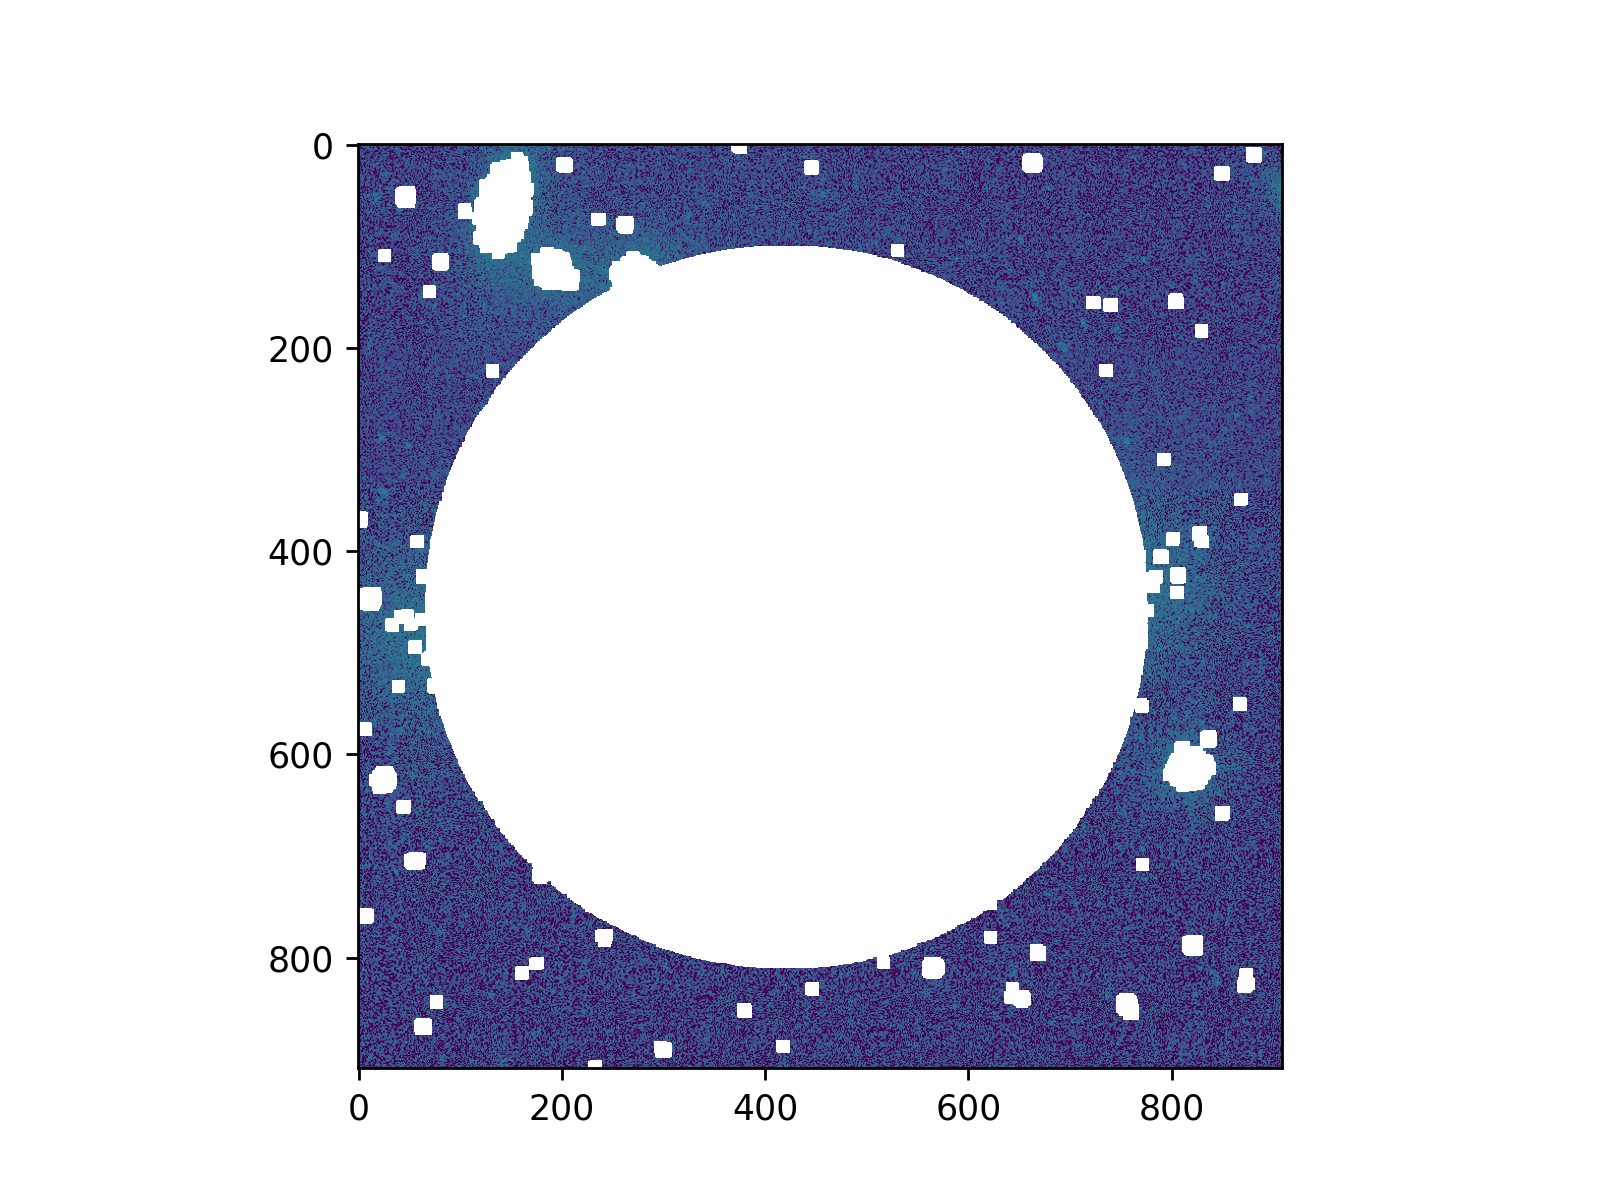

In [16]:
from photutils.segmentation import make_source_mask
from astropy.visualization import simple_norm
data_m1 =np.ma.array(img, mask = ~sky_region)
sourcemask = make_source_mask(data_m1, nsigma = 3, npixels = 3, dilate_size= 11)
data_m2 = np.ma.array(data_m1, mask = sourcemask)
norm = simple_norm(data_m2[sky_region], 'log')
plt.figure()
plt.imshow(data_m2*10, norm = norm )
sky_val, sky_sig = np.median(data_m2.data[~data_m2.mask]), np.std(data_m2.data[~data_m2.mask])

In [17]:
depth_i = -2.5*np.log10(5*sky_sig*np.sqrt(np.pi*(1.26/0.396)**2))+22.5

In [18]:

# -------------------------------- #
# ----- Running IRAF/Ellipse ----- #
# -------------------------------- #
sky_val_i = sky_val    # sky brightness (unit: pixel count)
rmax = 800.0    # maximum SMA (up to you)
kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.3, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.08,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":2, "mag0":mag0_i, "refer":sky_val_i,    # https://www.sdss.org/dr12/algorithms/magnitudes/
          "backgr":sky_val_i, "interp":"linear"}  # Here you can change input (default) parameter if needed!
iso_df_i = fit_ellipse(imgname, display=True, **kwargs)

removed 'NGC4442-i.tab'
removed 'colnames.lis'
removed 'NGC4442-i.dat'
Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.00    65.63(  0.27) 0.161(0.002)  86.97( 0.42) 0.012   29   0    20    0
   5.40    60.93(  0.20) 0.166(0.002)  86.61( 0.30) 0.014   31   0    10    0
   5.83    56.56(  0.24) 0.174(0.002)  86.57( 0.35) 0.013   34   0    10    0
   6.30    52.56(  0.21) 0.185(0.002)  86.73( 0.29) 0.011   36   0    10    0
   6.80    48.70(  0.18) 0.192(0.001)  86.70( 0.25) 0.013   39   0    10    0
   7.35    45.16(  0.18) 0.201(0.002)  86.85( 0.24) 0.011   41   0    10    0
   7.93    41.85(  0.20) 0.210(0.002)  86.83( 0.26) 0.012   44   0    10    0
   8.57    38.77(  0.17) 0.217(0.001)  86.83( 0.22) 0.014   48   0    10    0
 

IMAGE    t /data2/CLASS/astronomicalobservation/Combined_images/NGC4442-i.fits


In [19]:
iso_df_g['MAG'] = -2.5*np.log10(iso_df_g['INTENS']) + 22.5
iso_df_i['MAG'] = -2.5*np.log10(iso_df_i['INTENS']) + 22.5

In [20]:
totmag_i = -2.5*np.log10(np.sum(iso_df_i['INTENS'] * iso_df_i['NDATA'])) + 22.5

In [21]:
iso_df_g['MAG_LERR']

0          NaN
1     0.001705
2     0.001828
3     0.001929
4     0.002112
        ...   
91    0.088136
92    0.117543
93    0.108772
94    0.120101
95    0.155945
Name: MAG_LERR, Length: 96, dtype: float64

In [22]:
totmag_g = -2.5*np.log10(np.sum(iso_df_g['INTENS'] * iso_df_g['NDATA'])) + 22.5

In [23]:
print(totmag_g, totmag_r, totmag_i)

11.082662726905482 10.24559390953203 9.81665423816964


In [24]:
print(depth_g, depth_r, depth_i)

23.230425604591773 22.710467848596302 22.401729303041282


In [25]:
totmag_g-totmag_r

0.8370688173734528

In [26]:
totmag_r-totmag_i

0.4289396713623894

### 2) Drawing the Radial Profile

In [27]:
# Unit conversion
r_sma_g = iso_df_g['SMA'].values * pixel_scale    # pixel to arcsec
mu_g = iso_df_g['MAG'] - 2.5*np.log10(pixel_scale**(-2))    # mag/pixel^2 to mag/arcsec^2
e_mu_g = 2.5*iso_df_g['INT_ERR']/2.303/iso_df_g['INTENS']
r_sma_r = iso_df_r['SMA'].values * pixel_scale    # pixel to arcsec
mu_r = iso_df_r['MAG'] - 2.5*np.log10(pixel_scale**(-2))    # mag/pixel^2 to mag/arcsec^2
e_mu_r = 2.5*iso_df_r['INT_ERR']/2.303/iso_df_r['INTENS']
r_sma_i = iso_df_i['SMA'].values * pixel_scale    # pixel to arcsec
mu_i = iso_df_i['MAG'] - 2.5*np.log10(pixel_scale**(-2))    # mag/pixel^2 to mag/arcsec^2
e_mu_i = 2.5*iso_df_i['INT_ERR']/2.303/iso_df_i['INTENS']
### If you already set the mag0 in the unit of 'mag/arcsec^2',
### then you do not have to convert the unit from 'mag/pixel^2' to 'mag/arcsec^2'!

# Plotting
from matplotlib import gridspec
plt.figure(dpi = 150)

plt.xticks(visible=False)
plt.gca().invert_yaxis()
plt.subplots_adjust(hspace=0)
gs = gridspec.GridSpec(nrows = 2, ncols =1, height_ratios= [10, 3], width_ratios = [6])
ax0 = plt.subplot(gs[0])
ax0.set_title('NGC4442')
ax0.errorbar(r_sma_g, mu_g, yerr = e_mu_g, fmt = 'o', ms=3.0, c='g', capsize = 5, alpha=0.3, label = 'g band')#, linewidth=2.0, alpha=0.9)
ax0.errorbar(r_sma_r, mu_r, yerr = e_mu_r, fmt = 'o', ms=3.0, c='r', capsize = 5, alpha=0.3, label = 'r band')#, linewidth=2.0, alpha=0.9)
ax0.errorbar(r_sma_i, mu_i, yerr = e_mu_i, fmt = 'o', ms=3.0, c='k', capsize = 5, alpha=0.3, label = 'i band')#, linewidth=2.0, alpha=0.9)
ax0.axhline(depth_g, linestyle = '--', linewidth = 1, c = 'g')
ax0.axhline(depth_r, linestyle = '--', linewidth = 1, c = 'r')
ax0.axhline(depth_i, linestyle = '--', linewidth = 1, c = 'k')
cut = r_sma_g[np.argmin(np.abs(mu_g-depth_g))]
ax0.axvspan(cut, 400, color = 'gray', alpha = 0.3)
ax0.grid()
#ax.axhline(mag0_g - 2.5*np.log10(pixel_scale**(-2)), 0, 1,
#           linestyle='--', color='dodgerblue', linewidth=1.5, alpha=0.4)
#ax.axhline(mag0_i - 2.5*np.log10(pixel_scale**(-2)), 0, 1,
#           linestyle='--', color='magenta', linewidth=1.5, alpha=0.4)
#ax.axvline(1.5, 0, 1, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)
ax0.set_xlim([0.3, 400])
ax0.set_xscale('log')
ax0.set_ylim([27, 10])
ax0.legend()

ax0.set_ylabel(r"$\mu$ [mag ${\rm arcsec^{-2}}$]")
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.grid()
ax1.axvspan(cut, 800, color = 'gray', alpha = 0.3)
ax1.errorbar(r_sma_r, mu_g-mu_r, yerr = np.sqrt(e_mu_g**2+e_mu_r**2), fmt = 'o', ms=3.0, c='b', capsize = 2, alpha=0.2, label = 'g-r')#, linewidth=2.0, alpha=0.9)
ax1.errorbar(r_sma_r, mu_r-mu_i, yerr = np.sqrt(e_mu_r**2+e_mu_i**2), fmt = 'o', ms=3.0, c='r', capsize = 2, alpha=0.2, label = 'r-i')#, linewidth=2.0, alpha=0.9)
ax1.legend()
ax1.set_ylabel(r"Color")
ax1.set_xlabel("Semi-major Axis [arcsec]")

#ax1.plot(r_sma_g, mu_g-mu_i, 'x', ms = 3.0, color='black', alpha=0.6)
#plt.tight_layout()

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Semi-major Axis [arcsec]')

In [57]:
plt.figure()

ax0 = plt.subplot()
ax0.set_title('NGC4442')
ax0.set_xscale('log')
ax0.errorbar(r_sma_g, iso_df_g['A4'], iso_df_g['A4_ERR'], fmt = '.', c= 'r', capsize = 3, label = 'A4')
ax0.errorbar(r_sma_g, iso_df_g['B4'], iso_df_g['B4_ERR'], fmt = '.', c= 'b', capsize = 3, label = 'B4')
ax0.grid()
ax0.legend()
ax0.set_xlim(0.3, 600)
ax0.set_ylim(-0.3,0.3)
ax0.axvspan(cut, 600, color = 'gray', alpha = 0.3)
ax0.set_ylabel(r"Parameter value")
ax0.set_xlabel("Semi-major Axis [arcsec]")

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Semi-major Axis [arcsec]')

<IPython.core.display.Javascript object>


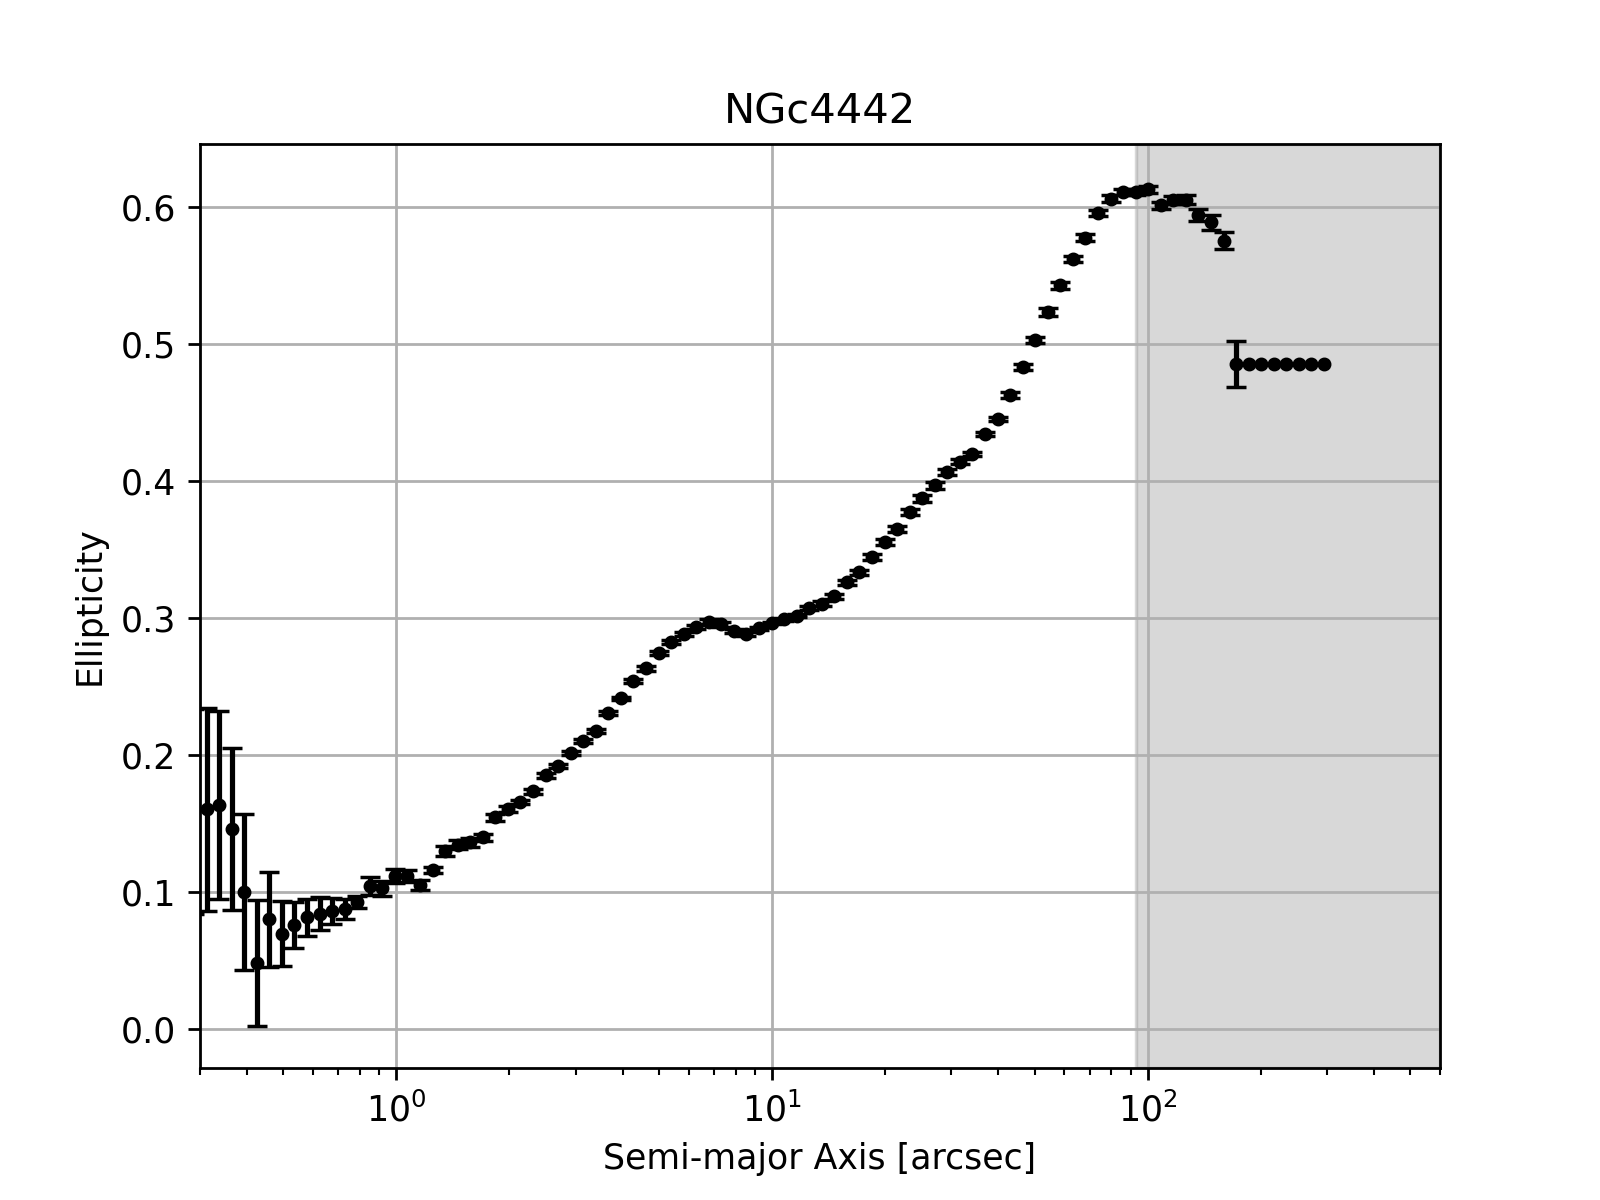

Text(0.5, 0, 'Semi-major Axis [arcsec]')

In [56]:
plt.figure()

ax0 = plt.subplot()
ax0.set_title('NGC4442')
ax0.set_xscale('log')
ax0.errorbar(r_sma_g, iso_df_g['ELLIP'], iso_df_g['ELLIP_ERR'], fmt = '.', c= 'k', capsize = 3)
ax0.grid()
ax0.set_xlim(0.3, 600)
ax0.axvspan(cut, 600, color = 'gray', alpha = 0.3)
ax0.set_ylabel(r"Ellipticity")
ax0.set_xlabel("Semi-major Axis [arcsec]")

In [52]:
iso_df_g.columns

Index(['SMA', 'INTENS', 'INT_ERR', 'PIX_VAR', 'RMS', 'ELLIP', 'ELLIP_ERR',
       'PA', 'PA_ERR', 'X0', 'X0_ERR', 'Y0', 'Y0_ERR', 'GRAD', 'GRAD_ERR',
       'GRAD_R_ERR', 'RSMA', 'MAG', 'MAG_LERR', 'MAG_UERR', 'TFLUX_E',
       'TFLUX_C', 'TMAG_E', 'TMAG_C', 'NPIX_E', 'NPIX_C', 'A3', 'A3_ERR', 'B3',
       'B3_ERR', 'A4', 'A4_ERR', 'B4', 'B4_ERR', 'NDATA', 'NFLAG', 'NITER',
       'STOP', 'A_BIG', 'SAREA'],
      dtype='object')

### 3) Sersic Profile Fitting

In [28]:
from scipy.optimize import curve_fit

#### Sersic profile (Useful reference: [Graham & Driver 2005](https://ui.adsabs.harvard.edu/abs/2005PASA...22..118G/abstract))

$\large \mu(R)=\mu_{e}+\frac{2.5b_{n}}{\rm ln(10)}\left[(R/R_{e})^{1/n}-1\right]$

where $b_{n}=2n-1/3$

In [29]:
def sersic(r, mu_e, re, n):
    bn = 2 * n - 1/3
    return mu_e + (2.5 * bn / np.log(10)) * ((r / re)**(1/n) - 1)

In [32]:
# Fitting range except r < 1.5 arcsec (Seeing effect)

print("\n*** g-band ***")
popt_g, pcov_g = curve_fit(sersic, r_sma_g, mu_g)
perr_g = np.sqrt(np.diag(pcov_g))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_g[1], perr_g[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_g[0], perr_g[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_g[2], perr_g[2]))

print("\n*** r-band ***")
popt_r, pcov_r = curve_fit(sersic, r_sma_r, mu_r)
perr_r = np.sqrt(np.diag(pcov_r))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_r[1], perr_r[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_r[0], perr_r[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_r[2], perr_r[2]))

print("\n*** i-band ***")
popt_i, pcov_i = curve_fit(sersic, r_sma_i, mu_i)
perr_i = np.sqrt(np.diag(pcov_i))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_i[1], perr_i[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_i[0], perr_i[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_i[2], perr_i[2]))


*** g-band ***
Effective radius: 32.87 +/- 0.77 arcsec
Surface brightness at effective radius: 20.97 +/- 0.06 mag/arcsec^2
Sersic index: 2.87 +/- 0.07

*** r-band ***
Effective radius: 29.93 +/- 0.63 arcsec
Surface brightness at effective radius: 19.99 +/- 0.06 mag/arcsec^2
Sersic index: 2.80 +/- 0.06

*** i-band ***
Effective radius: 33.33 +/- 0.78 arcsec
Surface brightness at effective radius: 19.80 +/- 0.06 mag/arcsec^2
Sersic index: 3.03 +/- 0.07


In [38]:
# Fitting range except r < 1.5 arcsec (Seeing effect)

print("\n*** g-band ***")
popt_g, pcov_g = curve_fit(sersic, r_sma_g[r_sma_g < cut], mu_g[r_sma_g < cut])
perr_g = np.sqrt(np.diag(pcov_g))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_g[1], perr_g[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_g[0], perr_g[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_g[2], perr_g[2]))

print("\n*** r-band ***")
popt_r, pcov_r = curve_fit(sersic, r_sma_r[r_sma_r < cut], mu_r[r_sma_r < cut])
perr_r = np.sqrt(np.diag(pcov_r))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_r[1], perr_r[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_r[0], perr_r[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_r[2], perr_r[2]))

print("\n*** i-band ***")
popt_i, pcov_i = curve_fit(sersic, r_sma_i[r_sma_i < cut], mu_i[r_sma_i< cut])
perr_i = np.sqrt(np.diag(pcov_i))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_i[1], perr_i[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_i[0], perr_i[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_i[2], perr_i[2]))


*** g-band ***
Effective radius: 31.98 +/- 1.87 arcsec
Surface brightness at effective radius: 20.92 +/- 0.12 mag/arcsec^2
Sersic index: 2.83 +/- 0.10

*** r-band ***
Effective radius: 31.07 +/- 1.86 arcsec
Surface brightness at effective radius: 20.08 +/- 0.12 mag/arcsec^2
Sersic index: 2.89 +/- 0.10

*** i-band ***
Effective radius: 30.93 +/- 1.79 arcsec
Surface brightness at effective radius: 19.67 +/- 0.11 mag/arcsec^2
Sersic index: 2.93 +/- 0.10


In [44]:
# Plotting for check
r_array = np.logspace(-1.0, 3.0, 1000)

fig, ax = plt.subplots(figsize=(6,4))
plt.title('NGC4442')
ax.plot(r_sma_g, mu_g, 'o', ms=3.0, color='green', alpha=0.6)#, linewidth=2.0, alpha=0.9)
ax.plot(r_array[r_array <= 1.5], sersic(r_array[r_array <= 1.5], *popt_g), '--', color='green', alpha=0.6, label = f'n[g] = {round(popt_g[2],2)}')
ax.plot(r_array[r_array > 1.5] , sersic(r_array[r_array > 1.5], *popt_g) , '-', color='green', alpha=0.7)
ax.plot(r_sma_r, mu_r, 'o', ms=3.0, color='red', alpha=0.6)#, linewidth=2.0, alpha=0.9)
ax.plot(r_array[r_array <= 1.5], sersic(r_array[r_array <= 1.5], *popt_r), '--', color='red', alpha=0.6, label = f'n[r] = {round(popt_r[2],2)}')
ax.plot(r_array[r_array > 1.5] , sersic(r_array[r_array > 1.5], *popt_r) , '-', color='red', alpha=0.7)
ax.plot(r_sma_i, mu_i, 'o', ms=3.0, color='black', alpha=0.6)#, linewidth=2.0, alpha=0.9)
ax.plot(r_array[r_array <= 1.5], sersic(r_array[r_array <= 1.5], *popt_i), '--', color='black', alpha=0.6, label = f'n[i] = {round(popt_i[2],2)}')
ax.plot(r_array[r_array > 1.5] , sersic(r_array[r_array > 1.5], *popt_i) , '-', color='black', alpha=0.7)
ax.legend()

ax.axhline(depth_g, linestyle = '--', linewidth = 1, c = 'g')
ax.axhline(depth_r, linestyle = '--', linewidth = 1, c = 'r')
ax.axhline(depth_i, linestyle = '--', linewidth = 1, c = 'k')
cut = r_sma_g[np.argmin(np.abs(mu_g-depth_g))]
ax.axvspan(cut, 800, color = 'gray', alpha = 0.3)
#ax.axvspan(0.3, 1.5, color = 'gray', alpha = 0.3)
#ax.axvline(1.5, 0, 1, linestyle='--', color='gray', linewidth=1, alpha=0.7)
ax.axvline(cut, 0, 1, linestyle='--', color='gray', linewidth=1, alpha=0.7)
#ax.axvline(popt_g[1], 0, 1, linestyle='-', color='green', linewidth=1.5, alpha=0.5)
#ax.axvline(popt_r[1], 0, 1, linestyle='-', color='red', linewidth=1.5, alpha=0.5)
#ax.axvline(popt_i[1], 0, 1, linestyle='-', color='black', linewidth=1.5, alpha=0.5)
ax.set_xlim([0.3, 800])
ax.set_xscale('log')
ax.set_ylim([26.5, 10])
ax.set_xlabel("Semi-major Axis [arcsec]")
ax.set_ylabel(r"$\mu$ [mag ${\rm arcsec^{-2}}$]")
plt.tight_layout()

<IPython.core.display.Javascript object>